In [268]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing

In [269]:
import pathlib
font_csvs =  [str(p) for p in pathlib.Path('preproc_data/afpdb').glob("*.csv")]
train_csvs = font_csvs[0:40]+font_csvs[50:90]
test_csvs = font_csvs[40:50]+font_csvs[90:100]
train_labels = np.array([0]*40*60+[1]*40*60)
test_labels = np.array([0]*10*60+[1]*10*60)
train_labels = train_labels.reshape((-1,1))
test_labels = test_labels.reshape((-1,1))
print("Train labels size: ", train_labels.size)
print("Test label size: ", test_labels.size)

Train labels size:  4800
Test label size:  1200


In [270]:
train_data = np.array([])
for csv in train_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if train_data.shape[0] == 0:
            train_data = row
        else:
            train_data = np.vstack((train_data, row))
train_data = np.moveaxis(train_data, 1, 2)
train_data.shape

(4800, 900, 1)

In [271]:
test_data = np.array([])
for csv in test_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if test_data.shape[0] == 0:
            test_data = row
        else:
            test_data = np.vstack((test_data, row))
test_data = np.moveaxis(test_data, 1, 2)
test_data.shape

(1200, 900, 1)

In [272]:
train = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

train = train.shuffle(len(train)).batch(2)
test = test.batch(16)

for d, l in train.take(1):
    print ("Data batch size: ", d.shape)
    print ("Labels batch size: ", l.shape)

Data batch size:  (2, 900, 1)
Labels batch size:  (2, 1)


In [287]:
model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(900,1)))
model.add(layers.Conv1D(16,8))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,4))
model.add(layers.Conv1D(32,4))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,2))
model.add(layers.Conv1D(32,2))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(8, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2))

model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_66 (Batc (None, 900, 1)            4         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 893, 16)           144       
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 446, 16)           0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 446, 16)           0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 443, 32)           2080      
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 440, 32)           4128      
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 220, 32)         

In [288]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

history = model.fit(train, epochs=200,
                       validation_data=(test))

Epoch 1/200
2400/2400 [==============================] - 22s 9ms/step - loss: 0.6960 - accuracy: 0.5160 - val_loss: 0.7303 - val_accuracy: 0.2558
Epoch 2/200
2400/2400 [==============================] - 20s 8ms/step - loss: 0.6865 - accuracy: 0.5352 - val_loss: 0.6922 - val_accuracy: 0.4983
Epoch 3/200
2400/2400 [==============================] - 20s 8ms/step - loss: 0.6927 - accuracy: 0.5127 - val_loss: 0.6932 - val_accuracy: 0.5058
Epoch 4/200
2400/2400 [==============================] - 20s 9ms/step - loss: 0.6950 - accuracy: 0.4954 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/200
2400/2400 [==============================] - 20s 8ms/step - loss: 0.6934 - accuracy: 0.4979 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/200
2400/2400 [==============================] - 20s 8ms/step - loss: 0.6934 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/200
2400/2400 [==============================] - 20s 8ms/step - loss: 0.6957 - accuracy: 0.5035 - val_loss: 0.6932 -

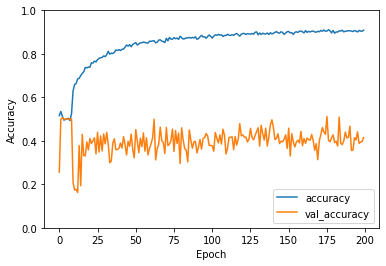

In [289]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [291]:
test_loss, test_acc = model.evaluate(test, verbose=2)

75/75 - 0s - loss: 2.2219 - accuracy: 0.4150
